In [17]:
import numpy as np
import random
from numpy.linalg import inv
from numpy.linalg import pinv
import matplotlib.pyplot as plt

import copy
import random

In [18]:
# This part of the code implements live plotting:

from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

def live_plot(data_dict, title, ylabel=None, xlabel=None, figsize=(7,5)):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show();

In [19]:
# defining the graph (weighted with rewards):

R = np.array([[0,-100,-100,-100,-5,-100],
              [-100,0,-100,-5,-100,100],
              [-100,-100,0,-5,-100,-100],
             [-100,-5,-5,0,-5,-100],
              [-5,-100,-100,-5,0,100],
              [-100,-5,-100,-100,-5,100]])

NumbertoSAPair = np.array([[0, 0],[0,4],[1,1],[1,3],[1,5],
                               [2,2],[2,3],[3,1],[3,2],[3,3],
                               [3,4],[4,0],[4,3],[4,4],[4,5],
                               [5,1],[5,4],[5,5]])

AlenVec = np.array([2,3,2,4,4,3])

# Inverse mapping: Given state-action pair, what is the curresponding number:
SAPairtoNumber = -1*np.ones((6,6))

for i in range(len(NumbertoSAPair)):
    SAPairtoNumber[NumbertoSAPair[i,0],NumbertoSAPair[i,1]]=i
    
StaActLen = np.sum(AlenVec); # Total number of state action pairs

In [20]:
def compute_Bellman_error(q_table, beta, noise):

    #Initialize Bellman error to 0:
    BE = np.zeros(StaActLen) # initialiser BE_Zap avec des 0
    
    for jj in range(StaActLen): # pour tous les state-action possibles

        x = NumbertoSAPair[jj,0] # x = state
        a = NumbertoSAPair[jj,1] # a = action

        # Calculate E[max_u Q(X_{t+1},u) | X_t=x, A_t = a]:
        max_Qfun_xtp1_Zap = 0; # max_Qfun_xtp1_Zap initialisé à 0
        NumOfXtp1 = 0; # NumOfXtp1 initialisé à 0
        for ll in range(StaActLen): # pour tous les state-action possibles l
            if(NumbertoSAPair[ll,0] == x): # si l part de x
                xplus1 = NumbertoSAPair[ll,1] # xplus1 prend action
                max_Qfun_xtp1_Zap = max_Qfun_xtp1_Zap + np.max(q_table[xplus1]) # max_Qfun_xtp1_Zap += max q_table à partir de action
                NumOfXtp1 = NumOfXtp1 + 1 # NumOfXtp1++
        max_Qfun_xtp1_Zap = max_Qfun_xtp1_Zap/NumOfXtp1 # max_Qfun_xtp1_Zap /= NumOfXtp1 (ie on prend l'average de toutes les greedy policies à partir de x)

        # BE(x,a) = R(x,a) + beta*E[max_u Q(X_{t+1},u) | X_t=x, A_t = a] - Q(x,a)
        BE[jj] = R[x,a] + beta*((1-noise)*np.max(q_table[a]) +  noise*max_Qfun_xtp1_Zap) - q_table[x,a]

    # MaximalBellmanError = max_{x,a} BE(x,a):  
    return np.max(abs(BE))

In [4]:
import math

def epsilon_greedy_policy(x, adjacencyMatrix, QTable, epsilon=0, environmentAwareness=False):
    """
    Returns action a (:= next wanted step in this problem)
    Takes greedy action with proba 1-epsilon
    adjacencyMatrix is the weighted reward matrix with -100 where no edges
    it will not be taken into account if environmentAwareness=False (then agent can choose -100 edges)
    """
    r = np.random.rand()
    if not environmentAwareness:
        if r > epsilon:
            return np.argmax(QTable[x])
        else:
            return np.random.choice(range(QTable[x].shape[0]))
    else:
        if r > epsilon:
            imax = -1
            Qmax = -1 * math.inf
            for i in range(QTable[x].shape[0]):
                if adjacencyMatrix[x][i] > -100 and QTable[x][i] > Qmax:
                    imax = i
                    Qmax = QTable[x][i]
            assert imax > -1, "Error : no possible action"
            return imax
        
        else:
            available = []
            for i in range(adjacencyMatrix[x].shape[0]):
                if adjacencyMatrix[x][i] > -100:
                    available.append(i)
            assert not len(available) == 0, "Error : no possible action"
            return np.random.choice(available)

In [5]:
# tests:

#QTable[1] = [1,1,1,1,4,1]
#print(epsilon_greedy_policy(1, R, QTable, epsilon=0, environmentAwareness=True))

In [6]:
def take_action(x, a, adjacencyMatrix, environmentAwareness=True, randomness=0.5):
    """
    Environment response to the action a from state x, returns: newState, reward
    when environmentAwareness=True, only possible actions will be randomly taken in case of random failure
    """
    r = np.random.rand()
    if not environmentAwareness:
        if r > randomness:
            return a, adjacencyMatrix[x][a]
        else:
            aa = np.random.choice(range(adjacencyMatrix[x].shape[0]))
            return aa, adjacencyMatrix[x][aa]
    else:
        available = []
        for i in range(adjacencyMatrix[x].shape[0]):
            if adjacencyMatrix[x][i] > -100:
                available.append(i)
        assert not len(available) == 0, "Error : no possible action"
        if r > randomness:
            assert a in available, "Error : the action in not possible"
            return a, adjacencyMatrix[x][a]
        else:
            aa = np.random.choice(available)
            return aa, adjacencyMatrix[x][aa]

In [7]:
# tests

#print(take_action(1, 5, R, environmentAwareness=False, randomness=0))
#print(take_action(1, 5, R, environmentAwareness=False, randomness=1))
#print(take_action(1, 1, R, environmentAwareness=True, randomness=0))
#print(take_action(1, 0, R, environmentAwareness=True, randomness=1))

#x = 1
#a = epsilon_greedy_policy(x, R, QTable, epsilon=1, environmentAwareness=True)
#print(a)
#print(take_action(x, a, R, environmentAwareness=True, randomness=0))

In [46]:
# Zap Q algorithm:
def Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=1,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=1000, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotTitle=None):
    """
    /!\: Not self-contained, will only work with R for now
    Plots every t_step iteration, on the go if livePlot=True (alterates wall-clock performance)
    policyRandomness : epsilon of epsilon greedy policy
    environmentRandomness : noise of environment (proba of going to a random state)
    """
    
    dataplot = collections.defaultdict(list) # history of Bellman Errors to plot
    xt = xStart; # start in state 0
    noise = environmentRandomness
    R = np.array([[0,-100,-100,-100,-5,-100],
              [-100,0,-100,-5,-100,100],
              [-100,-100,0,-5,-100,-100],
             [-100,-5,-5,0,-5,-100],
              [-5,-100,-100,-5,0,100],
              [-100,-5,-100,-100,-5,100]])
    
    AlenVec = np.array([2,3,2,4,4,3]) # Number of actions in each state; Ex: 2 = number of actions in state 0.

    # We need a mapping from state-action pair to a number between 1 and 18
    # This array is precisely that mapping
    # E.g. [State 0, Action 0] corresponds to the zeroeth state-action pair, 
    # [State 0, Action 4] corresponds to the first state-action pair

    NumbertoSAPair = np.array([[0, 0],[0,4],[1,1],[1,3],[1,5],
                               [2,2],[2,3],[3,1],[3,2],[3,3],
                               [3,4],[4,0],[4,3],[4,4],[4,5],
                               [5,1],[5,4],[5,5]])

    # Location of the state-action pair indicates the unique number which represents this pair (e.g. [5 5] = 17)

    # Inverse mapping: Given state-action pair, what is the curresponding number:
    SAPairtoNumber = -1*np.ones((6,6))

    for i in range(len(NumbertoSAPair)):
        SAPairtoNumber[NumbertoSAPair[i,0],NumbertoSAPair[i,1]]=i
        
    StaActLen = np.sum(AlenVec); # Total number of state action pairs

    # Initialize the Matrix gain for Zap Q:
    A_ZapQ = 10*np.eye(StaActLen)

    # Initialize the parameter vector for Zap Q:
    Qthetat_ZapQ = np.random.rand(StaActLen);

    # Initialize the Q function for Zap Q:
    Qfun_ZapQ = np.zeros((6,6))

    # Q-learning begins here:

    for t in range(T):
        
        if policyRandomness < 0:
            epsilon = 1./(t+1)
        else:
            epsilon = policyRandomness
        # ChooseAction will return the random action chosen in the current state AND the next state
        #xtp1at_m = ChooseAction(xt,noise,Qfun_ZapQ)
        at = epsilon_greedy_policy(xt,
                                   R,
                                   Qfun_ZapQ,
                                   epsilon=epsilon,
                                   environmentAwareness=policyEnvironmentAwareness)
        xtp1, _ = take_action(xt,
                              at,
                              R,
                              environmentAwareness=environmentEnvironmentAwareness,
                              randomness=environmentRandomness)
        #print(at)
        #print(xtp1)
        #break

        # Defining the stepsizes:
        alphat = 1./(t+2); # stepsize for parameter recursion
        gammat = np.power((t+1),-rho) # stepsize for matrix gain recursion

        num_sa_pair = int(SAPairtoNumber[xt][at]) # Mapping [S A] -> the curresponding number

        # Watkins' basis: Column vector with 1 at (x,a) and 0 elsewhere:
        psixtat = np.zeros(StaActLen)
        psixtat[num_sa_pair] = 1; # Basis are indicator functions

        # Watkins' basis evaluated at next state and the optimal policy:
        # Step 1: It takes values 1 at state-action pairs corresponding to xtp1, and all feasible actions
        psixtp1 = np.zeros(StaActLen)
        for jj in range(6):
            if SAPairtoNumber[xtp1,jj]>=0: # Is the action feasible?
                psixtp1[int(SAPairtoNumber[xtp1,jj])] = 1 # Take value 1


        # Zap Q-learning step:

        # Q(X_t,A_t):
        Qxt_Zap = np.dot(Qthetat_ZapQ,psixtat)

        # Q(X_t+1,a) with all feasible a's; Need to take minimum over all 'a' later:
        Qxtp1_Zap = np.multiply(Qthetat_ZapQ,psixtp1)

        # Optimal action for state xtp1, given the current parameter estimate:
        OptAct_xtp1 = np.argmax(Qxtp1_Zap)
        # Q-value at xtp1 and the optimal action:
        max_Qxtp1_Zap = np.max(Qxtp1_Zap)
        # max_Qxtp1_Zap = Qxtp1_Zap[OptAct_xtp1]

        # Basis function evaluated at xtp1 and the corresponding optimal action
        psixtp1_OptAct = np.zeros(StaActLen);
        psixtp1_OptAct[OptAct_xtp1] = 1;

        # Zap Q-learning begins here:

        # Estimating the A(\theta_t) matrix:
        A_ZapQ = A_ZapQ + gammat*( ( - np.outer(psixtat,psixtat) + beta*np.outer(psixtat,psixtp1_OptAct)) - A_ZapQ)
        Ainv_ZapQ = np.linalg.pinv(A_ZapQ)

        # Q update for SNR 2 (a) gain:

        Qthetat_ZapQ  =  Qthetat_ZapQ  - alphat*(np.dot(Ainv_ZapQ,psixtat))*((R[xt,at] + beta*max_Qxtp1_Zap - Qxt_Zap))

        # Zap Q-learning ends here



        xt = xtp1;

        # The code from here is to calculate the Bellman error at this iteration

        if((t%t_step)==0):
            for jj in range(StaActLen):
                Qfun_ZapQ[NumbertoSAPair[jj,0],NumbertoSAPair[jj,1]] = Qthetat_ZapQ[jj]
            # MaximalBellmanError = max_{x,a} BE(x,a):  
            dataplot['Zap_Q'].append(compute_Bellman_error(Qfun_ZapQ, beta, noise))
            if livePlot:
                live_plot(dataplot, title=plotTitle, ylabel='Bellman error', xlabel='t')

            # End of calculating Bellman Error
    if not livePlot:
        live_plot(dataplot, title=plotTitle, ylabel='Bellman error', xlabel='t')
    return Qfun_ZapQ

In [43]:
# Zap Q algorithm:
def Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=1,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=1000, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotTitle=None):
    """
    /!\: Not self-contained, will only work with R for now
    Plots every t_step iteration, on the go if livePlot=True (alterates wall-clock performance)
    policyRandomness : epsilon of epsilon greedy policy
    environmentRandomness : noise of environment (proba of going to a random state)
    """
    
    dataplot = collections.defaultdict(list) # history of Bellman Errors to plot
    xt = xStart; # start in state 0
    noise = environmentRandomness
    R = np.array([[0,-100,-100,-100,-5,-100],
              [-100,0,-100,-5,-100,100],
              [-100,-100,0,-5,-100,-100],
             [-100,-5,-5,0,-5,-100],
              [-5,-100,-100,-5,0,100],
              [-100,-5,-100,-100,-5,100]])
    
    AlenVec = np.array([2,3,2,4,4,3]) # Number of actions in each state; Ex: 2 = number of actions in state 0.

    # We need a mapping from state-action pair to a number between 1 and 18
    # This array is precisely that mapping
    # E.g. [State 0, Action 0] corresponds to the zeroeth state-action pair, 
    # [State 0, Action 4] corresponds to the first state-action pair

    NumbertoSAPair = np.array([[0, 0],[0,4],[1,1],[1,3],[1,5],
                               [2,2],[2,3],[3,1],[3,2],[3,3],
                               [3,4],[4,0],[4,3],[4,4],[4,5],
                               [5,1],[5,4],[5,5]])

    # Location of the state-action pair indicates the unique number which represents this pair (e.g. [5 5] = 17)

    # Inverse mapping: Given state-action pair, what is the curresponding number:
    SAPairtoNumber = -1*np.ones((6,6))

    for i in range(len(NumbertoSAPair)):
        SAPairtoNumber[NumbertoSAPair[i,0],NumbertoSAPair[i,1]]=i
        
    StaActLen = np.sum(AlenVec); # Total number of state action pairs

    # Initialize the Matrix gain for Zap Q:
    A_ZapQ = 10*np.eye(StaActLen)

    # Initialize the parameter vector for Zap Q:
    Qthetat_ZapQ = np.random.rand(StaActLen);

    # Initialize the Q function for Zap Q:
    Qfun_ZapQ = np.zeros((6,6))

    # Q-learning begins here:

    for t in range(T):
        
        if policyRandomness < 0:
            epsilon = 1./(t+1)
        else:
            epsilon = policyRandomness
        # ChooseAction will return the random action chosen in the current state AND the next state
        #xtp1at_m = ChooseAction(xt,noise,Qfun_ZapQ)
        at = epsilon_greedy_policy(xt,
                                   R,
                                   Qfun_ZapQ,
                                   epsilon=epsilon,
                                   environmentAwareness=policyEnvironmentAwareness)
        xtp1, _ = take_action(xt,
                              at,
                              R,
                              environmentAwareness=environmentEnvironmentAwareness,
                              randomness=environmentRandomness)
        #print(at)
        #print(xtp1)
        #break

        # Defining the stepsizes:
        alphat = 1./(t+2); # stepsize for parameter recursion
        gammat = np.power((t+1),-rho) # stepsize for matrix gain recursion

        num_sa_pair = int(SAPairtoNumber[xt][at]) # Mapping [S A] -> the curresponding number

        # Watkins' basis: Column vector with 1 at (x,a) and 0 elsewhere:
        psixtat = np.zeros(StaActLen)
        psixtat[num_sa_pair] = 1; # Basis are indicator functions

        # Watkins' basis evaluated at next state and the optimal policy:
        # Step 1: It takes values 1 at state-action pairs corresponding to xtp1, and all feasible actions
        psixtp1 = np.zeros(StaActLen)
        for jj in range(6):
            if SAPairtoNumber[xtp1,jj]>=0: # Is the action feasible?
                psixtp1[int(SAPairtoNumber[xtp1,jj])] = 1 # Take value 1


        # Zap Q-learning step:

        # Q(X_t,A_t):
        Qxt_Zap = np.dot(Qthetat_ZapQ,psixtat)

        # Q(X_t+1,a) with all feasible a's; Need to take minimum over all 'a' later:
        Qxtp1_Zap = np.multiply(Qthetat_ZapQ,psixtp1)

        # Optimal action for state xtp1, given the current parameter estimate:
        OptAct_xtp1 = np.argmax(Qxtp1_Zap)
        # Q-value at xtp1 and the optimal action:
        max_Qxtp1_Zap = np.max(Qxtp1_Zap)
        # max_Qxtp1_Zap = Qxtp1_Zap[OptAct_xtp1]

        # Basis function evaluated at xtp1 and the corresponding optimal action
        psixtp1_OptAct = np.zeros(StaActLen);
        psixtp1_OptAct[OptAct_xtp1] = 1;

        # Zap Q-learning begins here:

        # Estimating the A(\theta_t) matrix:
        A_ZapQ = A_ZapQ + gammat*( ( - np.outer(psixtat,psixtat) + beta*np.outer(psixtat,psixtp1_OptAct)) - A_ZapQ)
        Ainv_ZapQ = np.linalg.pinv(A_ZapQ)

        # Q update for SNR 2 (a) gain:

        Qthetat_ZapQ  =  Qthetat_ZapQ  - alphat*(np.dot(Ainv_ZapQ,psixtat))*((R[xt,at] + beta*max_Qxtp1_Zap - Qxt_Zap))

        # Zap Q-learning ends here



        xt = xtp1;

        # The code from here is to calculate the Bellman error at this iteration

        if((t%t_step)==0):
            #tt = int(np.floor(t/t_step))

            # Write the Q-function in matrix form (X x A matrix):

            for jj in range(StaActLen):
                Qfun_ZapQ[NumbertoSAPair[jj,0],NumbertoSAPair[jj,1]] = Qthetat_ZapQ[jj]

            #Initialize Bellman error to 0:
            BE_Zap = np.zeros(StaActLen)


            for jj in range(StaActLen):

                x = NumbertoSAPair[jj,0]
                a = NumbertoSAPair[jj,1]

                # Calculate E[max_u Q(X_{t+1},u) | X_t=x, A_t = a]:
                max_Qfun_xtp1_Zap = 0;
                NumOfXtp1 = 0;
                for ll in range(StaActLen):
                    if(NumbertoSAPair[ll,0] == x):
                        xplus1 = NumbertoSAPair[ll,1]
                        max_Qfun_xtp1_Zap = max_Qfun_xtp1_Zap + np.max(Qfun_ZapQ[xplus1])
                        NumOfXtp1 = NumOfXtp1 + 1
                max_Qfun_xtp1_Zap = max_Qfun_xtp1_Zap/NumOfXtp1

                # BE(x,a) = R(x,a) + beta*E[max_u Q(X_{t+1},u) | X_t=x, A_t = a] - Q(x,a)
                BE_Zap[jj] = R[x,a] + beta*((1-noise)*np.max(Qfun_ZapQ[a]) +  noise*max_Qfun_xtp1_Zap) - Qfun_ZapQ[x,a]

            # MaximalBellmanError = max_{x,a} BE(x,a):  
            dataplot['Zap_Q'].append(np.max(abs(BE_Zap)))
            if livePlot:
                live_plot(dataplot, title=plotTitle, ylabel='Bellman error', xlabel='t')

            # End of calculating Bellman Error
    if not livePlot:
        live_plot(dataplot, title=plotTitle, ylabel='Bellman error', xlabel='t')
    return Qfun_ZapQ

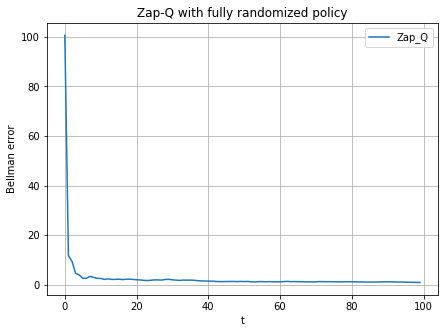

[[308.875127     0.           0.           0.         375.06644384
    0.        ]
 [  0.         385.42023971   0.         306.61189259   0.
  490.25874224]
 [  0.           0.         237.08656128 288.03183342   0.
    0.        ]
 [  0.         374.60243635 244.90407155 305.06287422 371.07956081
    0.        ]
 [304.67235853   0.           0.         303.85278482 380.50643334
  486.60323779]
 [  0.         387.294992     0.           0.         384.9829956
  495.80683421]]


In [47]:
Q = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=1,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=1000, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotTitle='Zap-Q with fully randomized policy')

print(Q)

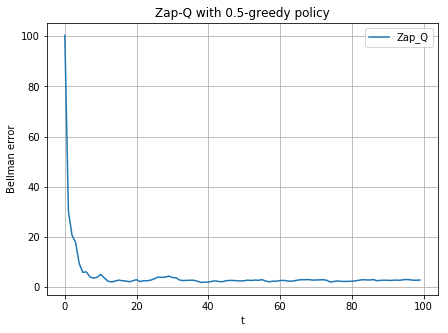

[[307.89865727   0.           0.           0.         374.35337087
    0.        ]
 [  0.         385.71656481   0.         306.10154249   0.
  490.00531448]
 [  0.           0.         236.17682595 286.2566174    0.
    0.        ]
 [  0.         373.71304947 240.81205688 303.22356819 370.01265347
    0.        ]
 [303.7021319    0.           0.         303.63134163 380.27949495
  486.39107634]
 [  0.         387.0856149    0.           0.         384.71314968
  495.81962292]]


In [48]:
Q = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.5,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=1000, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotTitle='Zap-Q with 0.5-greedy policy')

print(Q)

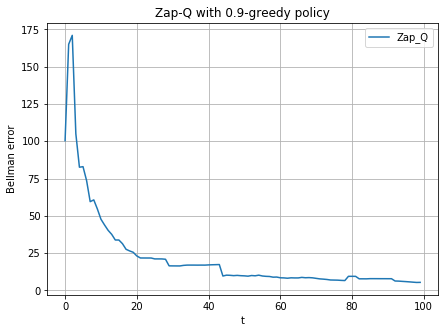

[[304.18002452   0.           0.           0.         373.01537101
    0.        ]
 [  0.         378.47769513   0.         305.01908313   0.
  486.95791452]
 [  0.           0.         230.39234916 285.35929509   0.
    0.        ]
 [  0.         373.08930789 246.9900841  308.99154833 369.53699068
    0.        ]
 [300.45763441   0.           0.         299.87825477 377.1040889
  483.61197674]
 [  0.         384.66857879   0.           0.         382.63607053
  493.66907168]]


In [49]:
Q = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.1,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=1000, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotTitle='Zap-Q with 0.9-greedy policy')

print(Q)

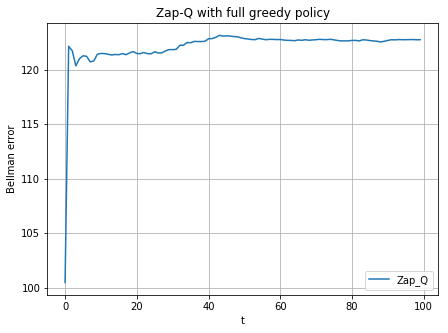

[[-3.63730264e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   8.22373712e+01  0.00000000e+00]
 [ 0.00000000e+00 -4.29079600e+00  0.00000000e+00  6.92383139e+00
   0.00000000e+00 -1.73433644e+00]
 [ 0.00000000e+00  0.00000000e+00 -3.63538241e+00  7.22626886e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  6.42119490e-01  1.07346408e-01  1.61874659e+01
  -1.92779012e+01  0.00000000e+00]
 [ 1.01884764e+01  0.00000000e+00  0.00000000e+00  5.85750787e-01
   8.77297114e-01  1.12558114e+02]
 [ 0.00000000e+00  6.00797368e+00  0.00000000e+00  0.00000000e+00
  -9.58898189e+00 -1.22052019e+01]]


In [50]:
Q = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=1000, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotTitle='Zap-Q with full greedy policy')

print(Q)

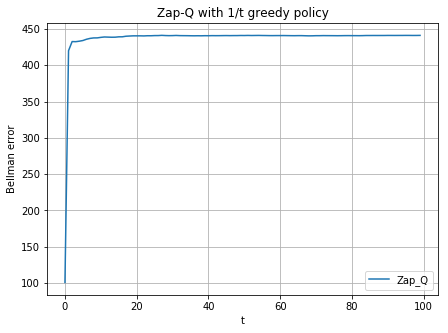

[[1.18688251e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.67828690e-02 0.00000000e+00]
 [0.00000000e+00 6.99161967e+01 0.00000000e+00 2.59234741e+02
  0.00000000e+00 6.31148432e-01]
 [0.00000000e+00 0.00000000e+00 1.88444243e+02 2.50728419e+02
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.16384386e+02 6.91778838e-03 6.76636017e-01
  3.27604938e+02 0.00000000e+00]
 [6.35666323e-01 0.00000000e+00 0.00000000e+00 3.55562585e+02
  2.61691950e+02 4.39328215e+02]
 [0.00000000e+00 2.03057845e+02 0.00000000e+00 0.00000000e+00
  7.78713327e+01 4.47864197e+02]]


In [51]:
Q = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=-1,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=1000, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotTitle='Zap-Q with 1/t greedy policy')

print(Q)

In [70]:
# vanilla Q learning :

def vanilla_Q_learning(livePlot=True,
                       initial_lr = 1.0,
                       min_lr = 0.003,
                       gamma = 0.8,
                       t_max = 100000,
                       iter_max = 10,
                       policyRandomness = 0,
                       policyEnvironmentAwareness = True,
                       environmentEnvironmentAwareness = True,
                       environmentRandomness = 0.2,
                       seed=0,
                       plotTitle=None):
    np.random.seed(seed)
    BE = np.zeros((6,6))
    xt1 = 4
    dataplot = collections.defaultdict(list)
    #print ('----- using Q Learning -----')
    q_table = np.zeros((6,6))
    for i in range(iter_max):
        obs = xt1
        total_reward = 0
        ## alpha: learning rate is decreased at each step
        alpha = max(min_lr, initial_lr * (0.85 ** (i//100)))
        for j in range(t_max):
            xt0 = xt1
            action = epsilon_greedy_policy(xt0,
                                   R,
                                   q_table,
                                   epsilon=policyRandomness,
                                   environmentAwareness=policyEnvironmentAwareness)
            xt1, reward = take_action(xt0,
                                  action,
                                  R,
                                  environmentAwareness=environmentEnvironmentAwareness,
                                  randomness=environmentRandomness)
            total_reward += (gamma ** j) * reward
            # update q table
            q_table[xt0][action] = q_table[xt0][action] + alpha * (reward + gamma *  np.max(q_table[xt1]) - q_table[xt0][action])
        #print('Iteration #%d -- Total reward = %d.' %(i+1, total_reward))
            if j%10000 == 0:
                #print(compute_Bellman_error(q_table, gamma, environmentRandomness))
                dataplot['Vanilla_Q'].append(compute_Bellman_error(q_table, gamma, environmentRandomness))
                if livePlot:
                    live_plot(dataplot, title=plotTitle, ylabel='Bellman error', xlabel='t')
    #solution_policy = np.argmax(q_table, axis=1)
    return q_table
    #solution_policy_scores = [run_episode(env, solution_policy, False) for _ in range(100)]
    #print("Average score of solution = ", np.mean(solution_policy_scores))
    # Animate it
    #run_episode(env, solution_policy, True)

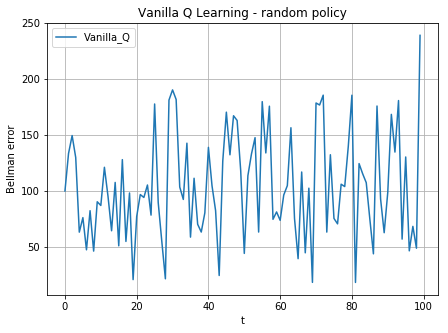

[[271.77269527   0.           0.           0.         339.71586909
    0.        ]
 [  0.         275.61815622   0.         275.61815622   0.
  444.71586909]
 [  0.           0.         266.77269527 275.61815622   0.
    0.        ]
 [  0.         350.77269527 215.49452497 280.61815622 339.71586909
    0.        ]
 [266.77269527   0.           0.         275.61815622 344.71586909
  455.77269527]
 [  0.         350.77269527   0.           0.         339.71586909
  455.77269527]]


In [71]:
q_table = vanilla_Q_learning(livePlot=True,
                       initial_lr = 1.0,
                       min_lr = 0.003,
                       gamma = 0.8,
                       t_max = 1000000, # one million iterations instead of 100 000
                       iter_max = 1, # one episode, we don't need to use episodes here
                       policyRandomness = 1, # full random
                       policyEnvironmentAwareness = True,
                       environmentEnvironmentAwareness = True,
                       environmentRandomness = 0.2,
                       plotTitle='Vanilla Q Learning - random policy')

print(q_table)

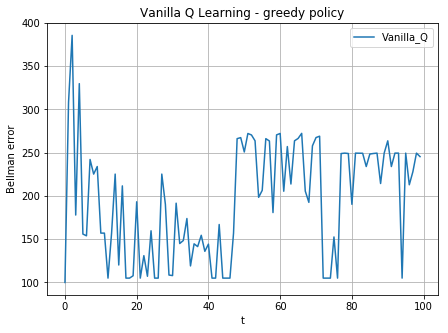

[[-5.  0.  0.  0. -5.  0.]
 [ 0. -5.  0. -5.  0. -5.]
 [ 0.  0. -5. -5.  0.  0.]
 [ 0. -5. -5. -5. -5.  0.]
 [-5.  0.  0. -5. -5. -5.]
 [ 0. -5.  0.  0. -5. -5.]]


In [72]:
q_table = vanilla_Q_learning(livePlot=True,
                       initial_lr = 1.0,
                       min_lr = 0.003,
                       gamma = 0.8,
                       t_max = 1000000, # one million iterations instead of 100 000
                       iter_max = 1, # one episode, we don't need to use episodes here
                       policyRandomness = 0, # full greedy
                       policyEnvironmentAwareness = True,
                       environmentEnvironmentAwareness = True,
                       environmentRandomness = 0.2,
                       seed=1,
                       plotTitle='Vanilla Q Learning - greedy policy')

print(q_table)